In [10]:
import ujson
import numpy 
import datetime
from collections import Counter, defaultdict

from features import *
import features
reload(features)
import sys, os
sys.path.append(os.getcwd())

from identify_similar import user_project_filter, print_datastats

## 1. Load Data

In [11]:
# loads pre-computed counts of each active block type per project for every user 
blockcounts = ujson.load(open('user_project_allblockcounts.json'))
# loads other stats 
othercounts = ujson.load(open('user_project_othercounts.json'))

print_datastats(blockcounts)

46320 users and 1546033 projects


## 2. Get Language Labels

The languages labels are inferred from the `namestrings_to_langs.py` script using `langid`.

In [13]:
isocodes = ujson.load(open('isocodes.json'))  # mapping from  iso code to language name
user_langs = ujson.load(open('user_inferredlangs.json'))  # mapping from userid to inferred language
# remove uncommon languages
lang_counts = Counter()
for user in user_langs:
    lang = user_langs[user]
    lang_counts[lang] += 1
    
user_langs = {user: lang for user, lang in user_langs.items() if lang_counts[lang]>=250 and user in blockcounts}
langset = set(user_langs.values())
print 'lang data created with', len(user_langs), 'users and', len(langset), 'languages', langset

# filter these users from code summaries
blockcounts = {user: blockcounts[user] for user in user_langs}
othercounts = {user: othercounts[user] for user in user_langs}

lang data created with 43160 users and 11 languages set([u'el', u'fr', u'en', u'zh', u'pt', u'ca', u'de', u'ko', u'it', u'th', u'es'])


Create a map from each language to the set of users assigned to that language.

In [17]:
lang_users = defaultdict(set)  
for user in user_langs:
    lang = user_langs[user]
    lang_users[lang].add(user)
print sorted([(len(lang_users[lang]), lang) for lang in lang_users])

[(257, u'th'), (291, u'el'), (322, u'fr'), (451, u'de'), (470, u'ca'), (838, u'pt'), (862, u'it'), (3605, u'ko'), (4926, u'es'), (9950, u'zh'), (21188, u'en')]


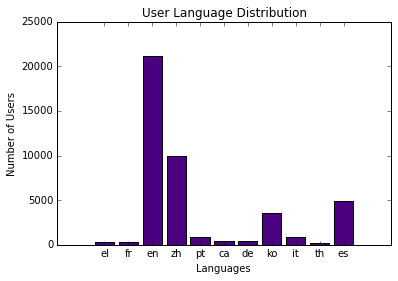

In [15]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

y_pos = np.arange(len(lang_users))
#print [len(lang_users[lang]) for lang in lang_users]
plt.bar(y_pos, [len(lang_users[lang]) for lang in lang_users], color = 'indigo', align='center')
plt.xticks(y_pos, lang_users.keys())
plt.ylabel('Number of Users')
plt.xlabel('Languages')
plt.title('User Language Distribution')
plt.savefig('langdist.png')
plt.show()

## 2. Filter Unoriginal Projects

Remove tutorials. Run the cells below only if we want to filter.

In [3]:
nontutorials = ujson.load(open('user_nontutorial_projects.json'))
blockcounts = user_project_filter(blockcounts, nontutorials)
othercounts = user_project_filter(othercounts, nontutorials)
print_datastats(blockcounts)

Filtered to 37986 users and 846119 projects


Identify frequent prefixes in project names. These are likely to be tutorials.

In [9]:
def most_common_prefixes():
    c = Counter()
    for user in blockcounts: 
        for projectname in blockcounts[user]: 
            c[projectname.split('_', 2)[-1]]+=1
    return c.most_common(200) 

print most_common_prefixes()

[(u'test', 1840), (u'BMI', 1816), (u'AndroidMashStarter', 1304), (u'MoleMash', 1246), (u'CoinFlipMediaOnly', 1123), (u'WhereIsNorthTemplate', 1120), (u'WhereAmI', 949), (u'MapTourMediaOnly', 938), (u'Calculator', 928), (u'TinyDB', 923), (u'TestApp', 866), (u'Magic8Ball', 803), (u'PaintPot', 796), (u'piano', 751), (u'TinyWebDbTemplate', 732), (u'HelloPurr', 724), (u'calculator', 691), (u'ListPicker', 670), (u'ball', 664), (u'btchat', 651), (u'CoinFlipExperiment', 635), (u'Piano', 631), (u'test2', 626), (u'CoinFlipProjects', 606), (u'compass', 595), (u'list', 578), (u'Test', 575), (u'CoinFlip', 571), (u'xylophone', 570), (u'Timer', 568), (u'GPS', 561), (u'HelloWorld', 560), (u'Canvas', 558), (u'test1', 553), (u'Dice', 553), (u'NoTextingWhileBusy', 549), (u'BallBounce', 540), (u'calculadora', 517), (u'new', 517), (u'Calculadora', 516), (u'clock', 511), (u'IHaveADreamStarter', 507), (u'TinyDBTemplate', 498), (u'CheckBox', 483), (u'Pong', 480), (u'game', 476), (u'Magic8BallTemplate', 474), 

Remove projects judged to be unoriginal by Eni's method. Run the cell below only we want to filter.

In [ ]:
originals = ujson.load(open('user_original_projects.json'))
blockcounts = user_project_filter(blockcounts, originals)
othercounts = user_project_filter(othercounts, originals)

Remove projects who names match patterns that indicate they are class projects.

In [6]:
def most_common_names_by_lang(lang):
    c = Counter()
    for user in lang_users[lang]: 
        for projectname in projectnames[user]: 
            c[projectname.split('_', 2)[-1]]+=1
    return c.most_common(50)      

for lang in ['zh', 'ca', 'pt', 'de', 'ko', 'it', 'es']:
    print most_common_names_by_lang(lang)
    
zh_examples = [entry for entry in c if 'ex_' in entry and c[entry] > 100]
pt_examples = ['Calculadora', 'calculadora', 'DataEHora', 'Lista']
ca_examples = ['CercleVersusPunt', 'Adreces_DavidMartinez', 'NomIntroduit', 'TallersSanJordi']
de_examples = ['Taschenrechner', 'Einkaufsliste', 'Mehrwertsteuer',  'ZufallsgeneratorLayout']
ko_examples = ['gawibawibo', 'ParisMapTour']
it_examples = ['calcolatrice', 'traduttore']
es_examples = ['prueba', 'brujula', 'examen', 'accelerometro', u'adivina_numero', 'Proyecto', 'Xilofono']

lang_tutorials = set(zh_examples + pt_examples + ca_examples + de_examples + ko_examples + it_examples + es_examples)
print len(lang_tutorials)

[(u'BMI', 379), (u'test', 288), (u'HelloPurr', 191), (u'piano', 140), (u'Piano', 106), (u'firstApp', 104), (u'TinyDB', 103), (u'Dice', 101), (u'bmi', 94), (u'test1', 92), (u'test2', 92), (u'ex_ATM', 92), (u'ball', 87), (u'Temp', 86), (u'Dice_1', 86), (u'Paint', 80), (u'new', 76), (u'paint', 76), (u'ex_commonFactor', 73), (u'Book', 73), (u'ex_F2C', 71), (u'ex_CanvasDraw', 71), (u'Weather', 71), (u'Ball', 71), (u'Ballot', 70), (u'Ballot_1', 68), (u'ex_ShowAlert', 68), (u'WhereAmI', 67), (u'score', 67), (u'hello', 66), (u'LocationSensor', 66), (u'ex_BMI', 64), (u'ex_idealBMI', 64), (u'a', 63), (u'ex_ScoreSearch', 62), (u'abc', 62), (u'MultiScreen', 62), (u'ex_Player', 62), (u'ex_Piano', 61), (u'app', 61), (u'ex_ButterFly', 61), (u'Movie', 61), (u'p121', 61), (u'a1', 60), (u'WebViewer', 60), (u'ex_Poker', 60), (u'ex_FeedButterFly', 60), (u'clock', 59), (u'ex_Temperature', 59), (u'ex_ListManage', 59)]
[(u'MoleMash', 28), (u'HelloPurr', 21), (u'Pong', 18), (u'prova', 17), (u'PaintPot', 16), 

NameError: name 'c' is not defined

## 2. Featurize (Code)

In [21]:
def combine_featfuncs(funclist):
    def combined(user):
        basedict = funclist[0](user)
        for f in funclist[1:]:
            basedict.update(f(user))
        return basedict
    return combined



In [37]:
langgroups = {'es': 'eur',
              'pt': 'eur', 
              'it': 'eur', 
              'de': 'eur', 
              'fr': 'eur', 
              'ca': 'eur', 
              'el': 'eur', 
              'nl': 'eur', 
              'pl': 'eur',
              'en': 'eur',
              'ko': 'asia', 
              'zh': 'asia', 
              'th': 'asia'}
user_lang_groups = {user: langgroups[lang] for user, lang in user_langs.items() if lang in langgroups.keys()}

In [40]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import LabelEncoder 


for user in user_lang_groups:
    y.append(userlabels[user])

        code_features.append(code_combined(projects))


        ctr+=1
        if ctr%1000==0:
            print ctr/1000,

        


y = numpy.array(y)

# timevec = DictVectorizer()

# Xtime = timevec.fit_transform(time_features) 

codevec = DictVectorizer()

Xcode = codevec.fit_transform(code_features)



# allvec = DictVectorizer()

# Xall = allvec.fit_transform(all_list)

# butvec = DictVectorizer()

# Xbut = butvec.fit_transform(but_list)


/Users/emmalurie/anaconda/lib/python2.7/site-packages/numpy/lib/function_base.py:1110: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/Users/emmalurie/anaconda/lib/python2.7/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42


In [41]:
from sklearn.preprocessing import scale
from numpy import *
# # convert to dense matrices since these are dense anyway
# Xtime = scale(Xtime.toarray())
Xcode = scale(Xcode.toarray())
# Xall = scale(Xall.toarray())
# Xall = scale(Xall.toarray())
# Xbut = scale(Xbut.toarray())


#### Static KFold Values

In [42]:
import pickle

In [43]:
if filter_tutorials:
    with open('filtered_kfold.pickle', 'rb') as f:
        foldindices = pickle.load(f)
else:
    with open('unfiltered_kfold.pickle', 'rb') as f:
        foldindices = pickle.load(f)

### Model Training and Testing

In [ ]:
from sklearn.cross_validation import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from  sklearn.metrics import f1_score 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline 
from plotcnf import plot_confusion_matrix
from sklearn.decomposition import PCA

print 'Chance is', max(numpy.bincount(y))/float(len(y))

### added later ### ************************    


labels = map(lambda x:x[0], sorted(langgroup_num_map.items(), key=lambda x:x[1]))  
# languages corresponding to class labels as a list

    
k = 70 #num neighbors for kNN

classifiers = [('logreg', LogisticRegression(penalty = 'l1'))]  # no knn because it's too slow 
#multi_class='multinomial', 
   

for modelname, model in classifiers:
    for featname, X in [('code', Xcode)]:
        print  'Building a', modelname, 'model with', X.shape[1], 'features'
    
        cvaccs = numpy.zeros(len(foldindices))
        #cvf1 = numpy.zeros(len(foldindices))
        for i, (trainidx, testidx) in enumerate(foldindices):
            
            print 'Fold', i+1
        
            ytrain = y[trainidx]
            ytest = y[testidx]
        
            Xtrain = X[trainidx, :]  
            Xtest = X[testidx, :]
            
            model.fit(Xtrain, ytrain)
            cvaccs[i] = model.score(Xtest, ytest)
            
            predictions = model.predict(Xtest)

#             pca = PCA(n_components=7)

#             reduced_train = pca.fit_transform(Xtrain)
#             reduced_test = pca.transform(Xtest)
            
#             model.fit(reduced_train, ytrain)
#             cvaccs[i] = model.score(reduced_test, ytest)
    
        
#             predictions = model.predict(reduced_test)

            #cvf1[i] = f1_score(ytest, predictions)
            
              
            #print '****', modelname, cvaccs[i]
        #analyze last fold only
        cnf_matrix = confusion_matrix(ytest, predictions)  
        plot_confusion_matrix(cnf_matrix, labels)
        plt.title('European and Asian Language Groupings')

        plt.show()
        coef = model.coef_
        print 'Average accuracy:', numpy.mean(cvaccs)

Chance is 0.678882455397
Building a logreg model with 569 features
Fold 1


### Testing different sized training setes

In [72]:
train_size = 100
accuracies = [] 
X = Xcode 

for n in range(200): 
    cvaccs = numpy.zeros(len(foldindices))
    for i, (trainidx, testidx) in enumerate(foldindices):

        ytrain = y[trainidx[0:train_size]]
        ytest = y[testidx]

        Xtrain = X[trainidx[0:train_size], :]  
        Xtest = X[testidx, :]

        model.fit(Xtrain, ytrain)
        cvaccs[i] = model.score(Xtest, ytest)

        predictions = model.predict(Xtest)

    print train_size, numpy.mean(cvaccs)
    accuracies.append((train_size, numpy.mean(cvaccs)))
    train_size+= 100



100 0.711129741853
200 0.783669935684
300 0.812526448775
400 0.822764666939
500 0.824200432356
600 0.837734530064
700 0.843854362557
800 0.851292179904
900 0.851786475332
1000 0.851245313319
1100 0.851574846931
1200 0.850115403078
1300 0.849762277456
1400 0.851456968317
1500 0.851504014395
1600 0.855623066511
1700 0.856941099571
1800 0.860189394576
1900 0.862401839907
2000 0.864214201636
2100 0.865744080813
2200 0.86689734042
2300 0.869298172824
2400 0.868662680998
2500 0.871228143926
2600 0.872946350342
2700 0.87318177684
2800 0.875841469865
2900 0.876076801631
3000 0.876994830849
3100 0.875535534916
3200 0.875676689765
3300 0.875158878778
3400 0.87492345228
3500 0.876359146234
3600 0.876476818764
3700 0.877842034177
3800 0.878477577528
3900 0.877394871247
4000 0.87826581949
4100 0.879866328445
4200 0.881890516348
4300 0.88238475693
4400 0.882926233056
4500 0.883961785228
4600 0.883867629921
4700 0.88478551787
4800 0.885138565377
4900 0.885397505774
5000 0.885585806421
5100 0.88549164

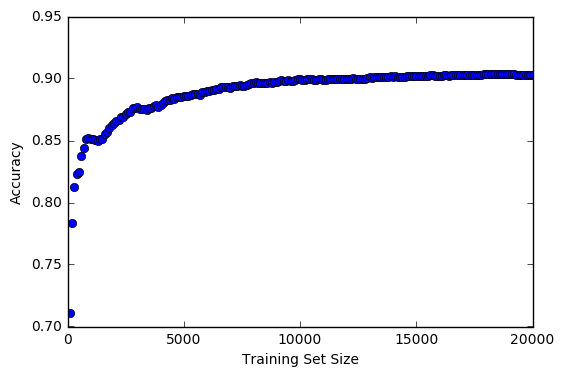

In [76]:
plt.plot([a[0] for a in accuracies],[a[1] for a in accuracies] , 'bo')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.show()

Confusion matrix, without normalization


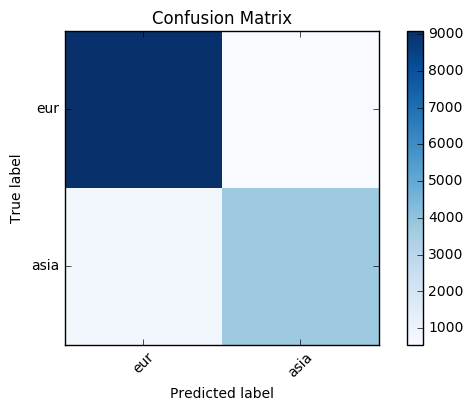

In [47]:
# eigenvalues = pca.explained_variance_
# print eigenvalues
#dictvectorizer has features_names
#codevec 
#inverse_tranform 

In [48]:
# plt.show()
# coef = model.coef_
# print 'Average accuracy:', numpy.mean(cvaccs)

### Coefs 

In [49]:
# sorted(zip(allvec.get_feature_names(), coef[0]), key=lambda tup: tup[1])

In [50]:
# from sklearn.metrics import f1_score
# f1_score(ytest, predictions)